# Plots

In [1]:
%matplotlib inline

/usr/local/miniconda3/envs/Belair-HPC-SD/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

## Load the Timings

For each class of machine, load the data.

In [3]:
vectors = ['addiction', 'age', 'foi', 'mcsims', 'years']

In [4]:
basedir = '../outputs/parallel_timings/hyperthreading'
timings = {k: {j: {} for j in ('stochastic', 'deterministic')} for k in vectors}

for pwd, dirs, files in os.walk(basedir):
    csv_files = [f for f in files if os.path.splitext(f.lower())[-1] == '.csv']
    if len(csv_files) < 1:
        continue
    
    cores = int(os.path.basename(pwd).split('-')[0])
    for f in csv_files:
        df = pd.read_csv(os.path.join(pwd, f))
        sd, vector = os.path.splitext(f)[0].split('_')
        timings[vector][sd][cores] = df

Now, load the single-core versions.

In [5]:
# basedir = '../outputs/timings'

# for pwd, dirs, files in os.walk(basedir):
#     csv_files = [f for f in files if os.path.splitext(f.lower())[-1] == '.csv']
#     if len(csv_files) < 1:
#         continue
#     for f in csv_files:
#         df = pd.read_csv(os.path.join(pwd, f))
#         sd, vector = os.path.splitext(f)[0].split('_')
#         timings[vector][sd][1] = df

## Plots for Each Vector

In [6]:
# labels
labs = {
    'addiction': 'Addiction levels',
    'age': 'Age groups',
    'foi': 'Levels of influence',
    'mcsims': 'Monte Carlo simulations',
    'years': 'Simulation years'
}

# Colors
colors = {
    4: 'blue',
    8: 'teal',
    16: 'green',
    36: 'orange',
    72: 'red'
}

markers = {
    4: 'o',
    8: 's',
    16: '*',
    36: 'd',
    72: 'D'
}

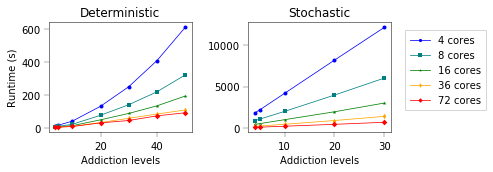

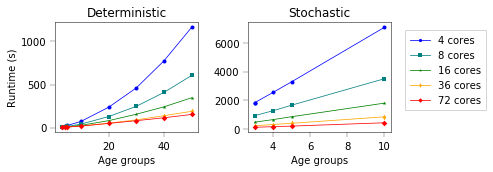

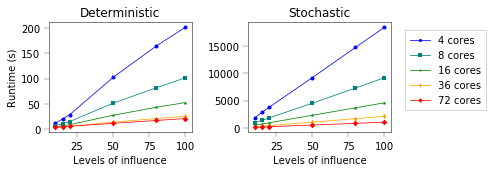

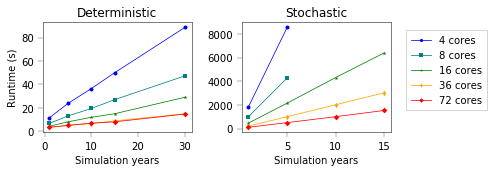

In [12]:
for vector in vectors:
    # Skip mcsims -- don't make a 2-panel plot for this one
    if vector == 'mcsims':
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 2.5), sharey=False)

    for i, sd in enumerate(('deterministic', 'stochastic')):
        for n in sorted(timings[vector][sd]):
            df = timings[vector][sd][n]
            
            # Fix ranges to match Hautahi's calculations
            if vector == 'years' and sd == 'deterministic':
                df = df[df.iloc[:,0] <= 30]
            elif vector == 'age' and sd == 'stochastic':
                df = df[df.iloc[:,0] <= 15]
            elif vector == 'addiction' and sd == 'stochastic':
                df = df[df.iloc[:,0] <= 30]
            elif vector == 'years' and sd == 'stochastic':
                df = df[df.iloc[:,0].isin([1,5,10,15])]
            
            # Set labels
            if i == 1:
                label = f'{n} core' + ('s' if n != 1 else '')
            else:
                label = ''
            
            # Plot
            axes[i].plot(df.iloc[:,0], df.iloc[:,1], '-', marker=markers[n], color=colors[n], label=label)
        
        # Axes properties
        if i == 0:
            axes[i].set_ylabel('Runtime (s)')
        
        #axes[i].set_yscale('log')
        axes[i].set_title(sd.capitalize())
        axes[i].set_xlabel(labs[vector])
    
    plt.legend(loc=(1.1, 0.20))
    plt.tight_layout()
    plt.savefig(f'./parallel-{vector}.pdf')

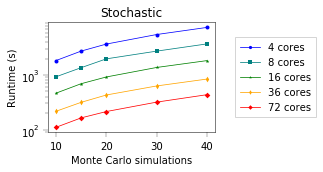

In [8]:
# Now mcsims -- stochastic only
fig, ax = plt.subplots(1, 1, figsize=(6.5, 2.5))

for n in sorted(timings['mcsims']['stochastic']):
    df = timings['mcsims']['stochastic'][n]
    df = df[df.iloc[:,0] <= 40]
    ax.plot(df.iloc[:,0], df.iloc[:,1], '-', marker=markers[n], color=colors[n], label=(f'{n} core' + ('s' if n != 1 else '')))

# Axes
ax.set_ylabel('Runtime (s)')
ax.set_yscale('log')
ax.set_title(sd.capitalize())
ax.set_xlabel(labs['mcsims'])
plt.legend(bbox_to_anchor=(1.7, 1.0))
plt.tight_layout()
plt.savefig(f'./parallel-mcsims.pdf')

## Scaling for Reference Models

I ran the default models and saved the output logs, so they need to be scraped for the timings. The files are named accoring to the formula `modeltype_awscores_awsprocs_coresused.txt`.

In [9]:
basedir = '../outputs/parallel_timings/hyperthreading/reference'

ref_timings = {k: {} for k in ('det', 'sto')}
timing_files = filter(lambda f: f.lower().endswith('.txt'), os.listdir(basedir))

for file in timing_files:
    with open(os.path.join(basedir, file), 'r') as f:
        runtime = float(re.search(r'([0-9.]+)\s+seconds', f.read()).group(1))
        kind, _, _, cores = os.path.splitext(file)[0].split('_')
        cores = int(cores)
        ref_timings[kind][cores] = runtime

ref = {j: np.array(sorted([[k, ref_timings[j][k]] for k in ref_timings[j]])) for j in ref_timings}

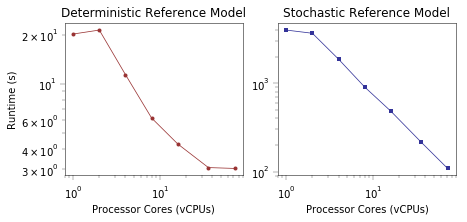

In [10]:
fig, [axl, axr] = plt.subplots(1, 2, figsize=(7, 2.8))
axl.plot(ref['det'][:,0], ref['det'][:,1], '-o', color='#993333')
axr.plot(ref['sto'][:,0], ref['sto'][:,1], '-s', color='#333399')
axl.set_ylabel('Runtime (s)')
axl.set_xlabel('Processor Cores (vCPUs)')
axr.set_xlabel('Processor Cores (vCPUs)')
axl.set_title('Deterministic Reference Model')
axr.set_title('Stochastic Reference Model')
#plt.tight_layout()
plt.savefig('reference-models.pdf')

# Log version
([ax.set_yscale('log') for ax in (axl, axr)])
([ax.set_xscale('log') for ax in (axl, axr)])
plt.savefig('reference-models-loglog.pdf')

### Export to CSV for Analysis

In [11]:
pd.DataFrame(ref['det'], columns=('cores', 'time')).to_csv('ref-deterministic-timings.csv', index=False)
pd.DataFrame(ref['sto'], columns=('cores', 'time')).to_csv('ref-stochastic-timings.csv', index=False)

**TO DO**

- get 4 core tests
- get 8-core re-tests
- get 16 core re-tests
- get 36 core re-tests
- check new years for 4, 8, 16, 36, and 72 [72 IP]
- do computations

watch out for odd things caused by bad 'steps' numbers. should be obvious

email about (1) steps issue and (2) run years last

do speedup fits and ahmdal's law stuff

These are good to go w/years:

- 4
- 8
- 16
- 36
- 72